## REINFORCE

Based on the [following materials](https://towardsdatascience.com/policy-gradient-methods-104c783251e0).

<img src="https://static.packt-cdn.com/products/9781789345803/graphics/assets/9170409d-15f1-453b-816a-6f601a89fcf2.png"/>

In [34]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [35]:
env = gym.make('CartPole-v1')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [36]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n

In [37]:
import torch.nn.functional as F
import torch.nn as nn
HIDDEN_SIZE = 256

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(obs_size, HIDDEN_SIZE)
        self.output_layer = nn.Linear(HIDDEN_SIZE, n_actions)

    def forward(self, x, t):
        x = F.relu(self.input_layer(x))
        x = self.output_layer(x)
        x = F.softmax(x/t, dim=0)
        return x

model = MyModel()

# simpliest neural network
# model = torch.nn.Sequential(
#              torch.nn.Linear(obs_size, HIDDEN_SIZE),
#              torch.nn.ReLU(),
#              torch.nn.Linear(HIDDEN_SIZE, n_actions),
#              torch.nn.Softmax(dim=0)
#      )
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
# hyperparameters
Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.99
score = []

In [39]:
for trajectory in tqdm(range(MAX_TRAJECTORIES)):
    curr_state = env.reset()
    done = False
    transitions = [] 
    temp = 900 / (trajectory+1)

    # iterating the trajectory
    for t in range(Horizon):
        act_prob = model(torch.from_numpy(curr_state).float(), temp)
        action = np.random.choice(np.array([0,1]), 
                 p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) 
        transitions.append((prev_state, action, t+1)) 
        if done: 
            break
    # iters until fallen
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in 
                   transitions]).flip(dims=(0,)) 
    batch_Gvals =[]
    # # interesting computation, isn't it?
    # for i in range(len(transitions)):
    #     new_Gval=0
    #     power=0
    #     for j in range(i,len(transitions)):
    #          new_Gval=new_Gval + ((gamma**power)*reward_batch[j]).numpy()
    #          power+=1
    #     batch_Gvals.append(new_Gval)

    temp_Gval = 0
    for i in range(len(transitions)):
        temp_Gval = gamma * temp_Gval + reward_batch[len(transitions)-i-1].numpy()
        batch_Gvals.append(temp_Gval)

    batch_Gvals = batch_Gvals[::-1]

    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions])) 
    action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions])) 

    pred_batch = model(state_batch, temp) 
    prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze() 
    # so, compute the gradient
    loss= -torch.sum(torch.log(prob_batch)*expected_returns_batch) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

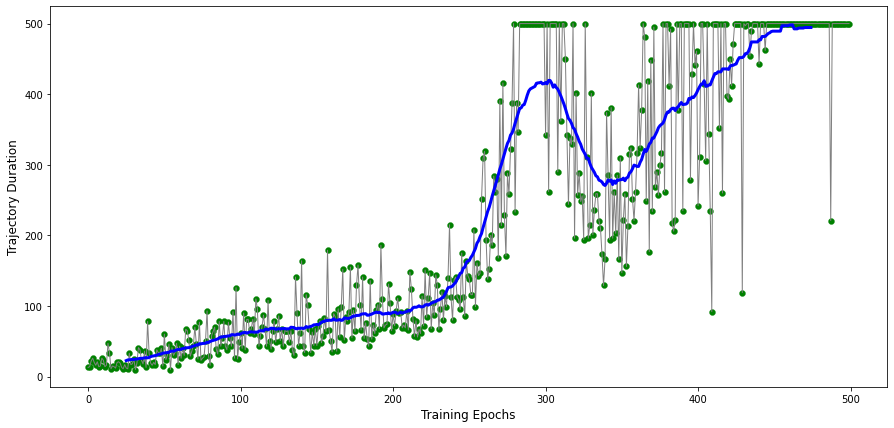

In [41]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)

    shift = int(N/2)
    for i in range(shift, conv_len + shift):
        y[i - shift] = kernel @ x[i-shift:i+shift]
        y[i - shift] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(np.arange(25, 25 + len(avg_score)), avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)
plt.show()

### Task

1. Change computation of `batch_Gvals`, so that it works faster
2. Sometimes even if we proceed training for thousands of epochs, we may face situations when cart pole does not run for all the time. What is the reason? Change the code in a way cart pole does not fall quickly in the late simulations. 

## Actor-Critic

Based on the [materials](https://github.com/nikhilbarhate99/Actor-Critic-PyTorch).

<img src="https://github.com/nikhilbarhate99/Actor-Critic/raw/master/gif/gif3.gif">

In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 374 kB 4.2 MB/s 
     |████████████████████████████████| 18.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.8 MB 50.2 MB/s 
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(8, 128)
        
        self.action_layer = nn.Linear(128, 4)
        self.value_layer = nn.Linear(128, 1)
        
        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine(state))
        
        state_value = self.value_layer(state)
        
        action_probs = F.softmax(self.action_layer(state))
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        
        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [ ]:
def test(n_episodes=5, name='LunarLander_TWO.pth'):
    env = gym.make('LunarLander-v2')
    policy = ActorCritic()
    
    policy.load_state_dict(torch.load('./preTrained/{}'.format(name)))
    
    render = True
    save_gif = False

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        running_reward = 0
        for t in range(10000):
            action = policy(state)
            state, reward, done, _ = env.step(action)
            running_reward += reward
            if render:
                 env.render()
                 if save_gif:
                     img = env.render(mode = 'rgb_array')
                     img = Image.fromarray(img)
                     img.save('./gif/{}.jpg'.format(t))
            if done:
                break
        print('Episode {}\tReward: {}'.format(i_episode, running_reward))
    env.close()

In [ ]:
import torch
import torch.optim as optim
import gym

def train():
    # Defaults parameters:
    #    gamma = 0.99
    #    lr = 0.02
    #    betas = (0.9, 0.999)
    #    random_seed = 543

    render = False
    gamma = 0.99
    lr = 0.02
    betas = (0.9, 0.999)
    random_seed = 543
    
    torch.manual_seed(random_seed)
    
    env = gym.make('LunarLander-v2')
    env.seed(random_seed)
    
    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=lr, betas=betas)
    print(lr,betas)
    
    running_reward = 0
    for i_episode in range(0, 10000):
        state = env.reset()
        for t in range(10000):
            action = policy(state)
            state, reward, done, _ = env.step(action)
            policy.rewards.append(reward)
            running_reward += reward
            if render and i_episode > 1000:
                env.render()
            if done:
                break
                    
        # Updating the policy :
        optimizer.zero_grad()
        loss = policy.calculateLoss(gamma)
        loss.backward()
        optimizer.step()
        policy.clearMemory()
        
        # saving the model if episodes > 999 OR avg reward > 200 
        #if i_episode > 999:
        #    torch.save(policy.state_dict(), './preTrained/LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
        
        if running_reward > 4000:
            torch.save(policy.state_dict(), './preTrained/LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
            print("########## Solved! ##########")
            test(name='LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
            break
        
        if i_episode % 20 == 0:
            running_reward = running_reward/20
            print('Episode {}\tlength: {}\treward: {}'.format(i_episode, t, running_reward))
            running_reward = 0

In [ ]:
train()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
<ipython-input-42-fb26534a3af9>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_probs = F

0.02 (0.9, 0.999)
Episode 0	length: 56	reward: -5.3042587663308085
Episode 20	length: 124	reward: -535.4136732711684
Episode 40	length: 83	reward: -377.2784142796166
Episode 60	length: 135	reward: -169.5526550341877
Episode 80	length: 94	reward: -70.4406611132556
Episode 100	length: 95	reward: -57.81122334723857
Episode 120	length: 201	reward: -102.21722582364347
Episode 140	length: 117	reward: -54.79442247856817
Episode 160	length: 88	reward: -122.76347691186189
Episode 180	length: 101	reward: -31.41787949577962
Episode 200	length: 116	reward: -88.49497413840297
Episode 220	length: 556	reward: -34.31303242245285
Episode 240	length: 999	reward: -14.369208708361501
Episode 260	length: 169	reward: -21.533207949741232
Episode 280	length: 100	reward: 2.5177678426868866
Episode 300	length: 323	reward: 21.177338412018134
Episode 320	length: 999	reward: 26.41543894038665
Episode 340	length: 137	reward: 64.20164691664114
Episode 360	length: 999	reward: 63.10760224754124
Episode 380	length: 999